# Rješenje zadatka


## Priprema okruženja


In [1]:
# Import IPython.
from IPython import *
from IPython.display import *


In [2]:
# Import standard library.
import copy
import math
import numbers
import six
import time


In [3]:
# Import SciPy packages.
import matplotlib as mpl
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import sympy as sym
from mpl_toolkits.mplot3d import Axes3D


In [4]:
# Import Shapely.
import shapely as sh
import shapely.geometry as gm


In [5]:
%matplotlib inline


In [6]:
#sym.init_printing()


In [7]:
plt.style.use('default')


In [8]:
from usefulness import *


## Učitavanje podataka


In [9]:
df = pd.concat(
    (
        read_tsv(
            'data/coordinates.tsv',
            header = False,
            index = False,
            as_str = False,
            names = [
                'x_0',
                'y_0',
                'x_1',
                'y_1',
                'x_2',
                'y_2'
            ]
        ),
        read_tsv(
            'data/sorted_description.tsv',
            header = False,
            index = False,
            as_str = False,
            names = [
                'a',
                'c',
                'b',
                'alpha',
                'gamma',
                'beta'
            ]
        ),
        read_tsv(
            'data/singular_values.tsv',
            header = False,
            index = False,
            as_str = False,
            names = [
                'sv_edge_0',
                'sv_edge_1',
                'sv_edge_2',
                'sv_angle_0',
                'sv_angle_1',
                'sv_angle_2'
            ]
        ),
        read_tsv(
            'data/eigenvalues.tsv',
            header = False,
            index = False,
            as_str = False,
            names = ['l_0']
        )
    ),
    axis = 1
).copy(deep = True)
df_balanced = pd.concat(
    (
        read_tsv(
            'data/auxiliary_coordinates.tsv',
            header = False,
            index = False,
            as_str = False,
            names = [
                'x_0',
                'y_0',
                'x_1',
                'y_1',
                'x_2',
                'y_2'
            ]
        ),
        read_tsv(
            'data/auxiliary_eigenvalues.tsv',
            header = False,
            index = False,
            as_str = False,
            names = ['l_0']
        )
    ),
    axis = 1
).copy(deep = True)


In [10]:
x = np.load('data/arrays/x.npy')
y = np.load('data/arrays/y.npy')

X = np.load('data/arrays/X.npy')
Y = np.load('data/arrays/Y.npy')

L_0 = np.load('data/arrays/L.npy')


In [11]:
I = np.array(
    np.isnan(L_0),
    dtype = bool,
    copy = True,
    order = 'F',
    subok = False,
    ndmin = 2
)

#L_0[I] = 1.0e-16

X = np.ma.MaskedArray(X, mask = I, copy = True, subok = False)
Y = np.ma.MaskedArray(Y, mask = I, copy = True, subok = False)
L_0 = np.ma.MaskedArray(L_0, mask = I, copy = True, subok = False)

del I


In [12]:
# Compute quantiles (20 % intervals) of lambda_0 on `df_balanced`.
l_0_quant = np.array(
    np.concatenate(
        (
            [min(df_balanced.l_0.min(), df.l_0.min())],
            [
                df_balanced.l_0.quantile(float("0.{p:02d}".format(p = i)))
                    for i in range(5, 96, 5)
            ],
            [max(df_balanced.l_0.max(), df.l_0.max())]
        )
    ),
    dtype = float,
    copy = True,
    order = 'F',
    subok = False,
    ndmin = 1
)
try:
    del i
except (NameError, UnboundLocalError):
    pass

# Compute base 10 logarithms of quantiles `l_0_quant`.
l_0_log10_quant = np.array(
    np.log10(l_0_quant),
    dtype = float,
    copy = True,
    order = 'F',
    subok = False,
    ndmin = 1
)

# Extend extreme levels by 10^(-8).
l_0_quant[0] -= 1.0e-8
l_0_quant[-1] += 1.0e-8
l_0_log10_quant[0] -= 1.0e-8
l_0_log10_quant[-1] += 1.0e-8


In [13]:
# Set limits for plotting data from dataframes.
lim = {
    'x_0' : (0.0, 1.0),
    'y_0' : (-1.0, 1.0),
    'x_1' : (0.0, 0.5),
    'y_1' : (0.0, 0.9),
    'x_2' : (-1.0, 0.0),
    'y_2' : (-1.0, 1.0),
    'a' : (0.0, 2.0),
    'c' : (0.5, 1.0),
    'b' : (0.0, 1.0),
    'alpha' : (0.0, 2.5),
    'gamma' : (1.50, 3.25),
    'beta' : (2.00, 3.25),
    'sv_edge_0' : (2.5, 4.5),
    'sv_edge_1' : (0.0, 1.5),
    'sv_edge_2' : (0.0, 1.5),
    'sv_angle_0' : (8.885765865, 8.885765895),
    'sv_angle_1' : (0.0, 4.5),
    'sv_angle_2' : (0.0, 4.5),
    'l_0' : (0.0, 6000.0),
    'l_0_log10' : (1.5, 4.0),
    'l_0_inv' : (0.00, 0.02)
}

# Set tick positions for plotting data from dataframes.
ticks = {
    'x_0' : tuple([0.5]),
    'y_0' : tuple([0.0]),
    'x_1' : (0.0, 0.1, 0.2, 0.3, 0.4, 0.5),
    'x_1_thirds' : (
        0.0000000000000000000000000000000000000000000000000000000000000000,
        0.1666666666666666666666666666666666666666666666666666666666666667,
        0.3333333333333333333333333333333333333333333333333333333333333333,
        0.5000000000000000000000000000000000000000000000000000000000000000
    ),
    'y_1' : (0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9),
    'y_1_thirds' : (0.0, 0.3, 0.6, 0.9),
    'x_2' : tuple([-0.5]),
    'y_2' : tuple([0.0]),
    'a' : tuple([1.0]),
    'c' : (0.5, 0.6, 0.7, 0.8, 0.9, 1.0),
    'b' : (0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0),
    'alpha' : (0.0, 0.5, 1.0, 1.5, 2.0, 2.5),
    'gamma' : (1.50, 1.75, 2.00, 2.25, 2.50, 2.75, 3.00, 3.25),
    'beta' : (2.00, 2.25, 2.50, 2.75, 3.00, 3.25),
    'sv_edge_0' : (2.5, 3.0, 3.5, 4.0, 4.5),
    'sv_edge_1' : (0.00, 0.25, 0.50, 0.75, 1.00, 1.25, 1.50),
    'sv_edge_2' : (0.00, 0.25, 0.50, 0.75, 1.00, 1.25, 1.50),
    'sv_angle_0' : (8.88576587, 8.88576588, 8.88576589),
    'sv_angle_1' : (0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5),
    'sv_angle_2' : (0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5),
    'l_0' : (0.0, 1000.0, 2000.0, 3000.0, 4000.0, 5000.0, 6000.0),
    'l_0_log10' : (2.0, 2.5, 3.0, 3.5),
    'l_0_inv' : (0.000, 0.005, 0.010, 0.015, 0.020)
}

# Set tick labels for plotting data from dataframes.
ticklabels = {
    'x_0' : tuple(
        "$ {tick:.1f} $".format(tick = ticks['x_0'][i])
            for i in range(len(ticks['x_0']))
    ),
    'y_0' : tuple(
        "$ {tick:d} $".format(tick = int(round(ticks['y_0'][i])))
            for i in range(len(ticks['y_0']))
    ),
    'x_1' : tuple(
        "$ {tick:.1f} $".format(tick = ticks['x_1'][i])
            for i in range(len(ticks['x_1']))
    ),
    'x_1_thirds' : tuple(
        "$ {tick:.2f} $".format(tick = ticks['x_1_thirds'][i])
            for i in range(len(ticks['x_1_thirds']))
    ),
    'y_1' : tuple(
        "$ {tick:.1f} $".format(tick = ticks['y_1'][i])
            for i in range(len(ticks['y_1']))
    ),
    'y_1_thirds' : tuple(
        "$ {tick:.1f} $".format(tick = ticks['y_1_thirds'][i])
            for i in range(len(ticks['y_1_thirds']))
    ),
    'x_2' : tuple(
        "$ {tick:.1f} $".format(tick = ticks['x_2'][i])
            for i in range(len(ticks['x_2']))
    ),
    'y_2' : tuple(
        "$ {tick:d} $".format(tick = int(round(ticks['y_2'][i])))
            for i in range(len(ticks['y_2']))
    ),
    'a' : tuple(
        "$ {tick:d} $".format(tick = int(round(ticks['a'][i])))
            for i in range(len(ticks['a']))
    ),
    'c' : tuple(
        "$ {tick:.1f} $".format(tick = ticks['c'][i])
            for i in range(len(ticks['c']))
    ),
    'b' : tuple(
        "$ {tick:.1f} $".format(tick = ticks['b'][i])
            for i in range(len(ticks['b']))
    ),
    'alpha' : tuple(
        "$ {tick:.2f} $".format(tick = ticks['alpha'][i])
            for i in range(len(ticks['alpha']))
    ),
    'gamma' : tuple(
        "$ {tick:.2f} $".format(tick = ticks['gamma'][i])
            for i in range(len(ticks['gamma']))
    ),
    'beta' : tuple(
        "$ {tick:.2f} $".format(tick = ticks['beta'][i])
            for i in range(len(ticks['beta']))
    ),
    'sv_edge_0' : tuple(
        "$ {tick:.1f} $".format(tick = ticks['sv_edge_0'][i])
            for i in range(len(ticks['sv_edge_0']))
    ),
    'sv_edge_1' : tuple(
        "$ {tick:.1f} $".format(tick = ticks['sv_edge_1'][i])
            for i in range(len(ticks['sv_edge_1']))
    ),
    'sv_edge_2' : tuple(
        "$ {tick:.1f} $".format(tick = ticks['sv_edge_2'][i])
            for i in range(len(ticks['sv_edge_2']))
    ),
    'sv_angle_0' : tuple(
        "$ {tick:d} $".format(
            tick = int(round(1.0e+8 * (ticks['sv_angle_0'][i] - 8.8857658)))
        ) for i in range(len(ticks['sv_angle_0']))
    ),
    'sv_angle_1' : tuple(
        "$ {tick:.1f} $".format(tick = ticks['sv_angle_1'][i])
            for i in range(len(ticks['sv_angle_1']))
    ),
    'sv_angle_2' : tuple(
        "$ {tick:.1f} $".format(tick = ticks['sv_angle_2'][i])
            for i in range(len(ticks['sv_angle_2']))
    ),
    'l_0' : tuple(
        "$ {tick:d} $".format(tick = int(round(ticks['l_0'][i])))
            for i in range(len(ticks['l_0']))
    ),
    'l_0_log10' : tuple(
        "$ {tick_d:.2f} \\cdot 10^{{{tick_e:d}}} $".format(
            tick_d = (
                10.0 ** ticks['l_0_log10'][i] /
                10.0 ** int(round(math.floor(ticks['l_0_log10'][i])))
            ),
            tick_e = int(round(math.floor(ticks['l_0_log10'][i])))
        ) for i in range(len(ticks['l_0_log10']))
    ),
    'l_0_inv' : tuple(
        "$ {tick:.3f} $".format(tick = ticks['l_0_inv'][i])
            for i in range(len(ticks['l_0_inv']))
    )
}
try:
    del i
except (NameError, UnboundLocalError):
    pass


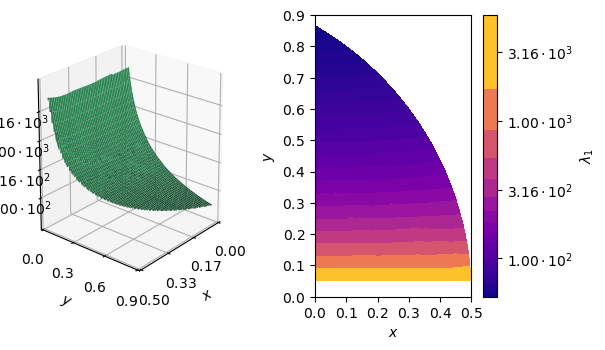

In [14]:
# Create a figure.
fig = plt.figure(num = 'Eigenvalues', figsize = (6.5, 3.65625))

# Create subplots.
ax0 = fig.add_subplot(1, 2, 1, projection = '3d')
ax1 = fig.add_subplot(1, 2, 2)

# Set the view on the 3D plot.
ax0.view_init(20.0, 40.0)

# Set aspect of the 2D plot to equal.
ax1.set_aspect('equal')

# Plot lambda_0 as surface and contours on the domain of characteristic points.
ax0.plot_surface(X, Y, np.log10(L_0.data), color = 'seagreen')
cs = ax1.contourf(
    X,
    Y,
    np.log10(L_0),
    levels = l_0_log10_quant,
    cmap = plt.cm.plasma
)

# Set axis labels on the 3D plot.
ax0.set_xlabel("$ x $")
ax0.set_ylabel("$ y $")
ax0.set_zlabel("$ \lambda_{1} $")

# Set ticks on the 3D plot.
ax0.set_xticks(ticks['x_1_thirds'])
ax0.set_yticks(ticks['y_1_thirds'])
ax0.set_zticks(ticks['l_0_log10'])

# Set tick labels on the 3D plot.
ax0.set_xticklabels(ticklabels['x_1_thirds'])
ax0.set_yticklabels(ticklabels['y_1_thirds'])
ax0.set_zticklabels(ticklabels['l_0_log10'])

# Set axis limits on the 3D plot.
ax0.set_xlim(lim['x_1'])
ax0.set_ylim(lim['y_1'])
ax0.set_zlim(lim['l_0_log10'])

# Set axis labels on the 2D plot.
ax1.set_xlabel("$ x $")
ax1.set_ylabel("$ y $")

# Set ticks on the 2D plot.
ax1.set_xticks(ticks['x_1'])
ax1.set_yticks(ticks['y_1'])

# Set tick labels on the 2D plot.
ax1.set_xticklabels(ticklabels['x_1'])
ax1.set_yticklabels(ticklabels['y_1'])

# Set axis limits on the 2D plot.
ax1.set_xlim(lim['x_1'])
ax1.set_ylim(lim['y_1'])

# Create a colorbar for the contour plot (2D plot
cbar = fig.colorbar(
    cs,
    ax = ax1,
    ticks = ticks['l_0_log10'],
    spacing = 'proportional'
)

# Set the label for the colorbar.
cbar.set_label("$ \lambda_{1} $")

# Set ticklabels for the colorbar.
cbar.ax.set_yticklabels(ticklabels['l_0_log10'])

# Save the figure.
fig.savefig('../eigenvalues.pdf', bbox_inches = 'tight')

# Show the plots.
plt.show()


In [15]:
# Free the memory.
del fig
del ax0
del ax1


## Balansiranje skupa podataka


In [16]:
quants = tuple(
    df.loc[(df.l_0 >= l_0_quant[i]) & (df.l_0 < l_0_quant[i + 1])].copy(
        deep = True
    ) for i in range(int(l_0_quant.size) - 1)
)
try:
    del i
except (NameError, UnboundLocalError):
    pass


In [17]:
display(
    tuple(
        float(quants[i].shape[0]) / float(df.shape[0])
            for i in range(len(quants))
    )
)
try:
    del i
except (NameError, UnboundLocalError):
    pass


(0.004828022184288254,
 0.013568575091549146,
 0.020967764784213173,
 0.027742755753252916,
 0.03337382508977837,
 0.038994269767178305,
 0.04324678958216757,
 0.04789773411436383,
 0.051657092668276894,
 0.05487105205374661,
 0.057241236426997966,
 0.06146896537069436,
 0.06285459799831422,
 0.06438277813586814,
 0.06780568915080641,
 0.06684504288820733,
 0.06875482536601951,
 0.07007936620366763,
 0.07295687805016256,
 0.0704627393204468)

In [18]:
display(
    tuple(
        (
            float(max(quants[j].shape[0] for j in range(len(quants)))) /
            float(quants[i].shape[0])
        ) for i in range(len(quants))
    )
)
try:
    del j
except (NameError, UnboundLocalError):
    pass
try:
    del i
except (NameError, UnboundLocalError):
    pass


(15.111131487254722,
 5.376900489396411,
 3.479478084621231,
 2.6297631965277333,
 2.186050830370881,
 1.8709640797420644,
 1.686989456443853,
 1.5231801545343635,
 1.4123303167420815,
 1.3296059637912674,
 1.2745510510278264,
 1.186889637887823,
 1.1607245988928174,
 1.1331738108007756,
 1.0759698627632766,
 1.0914328856393547,
 1.0611164767239714,
 1.0410607572867052,
 1.0,
 1.0353965621230399)

In [19]:
df_sample = pd.concat(
    generate_subdf(quants, 50),
    axis = 0
).sort_index(axis = 0, inplace = False).copy(deep = True)


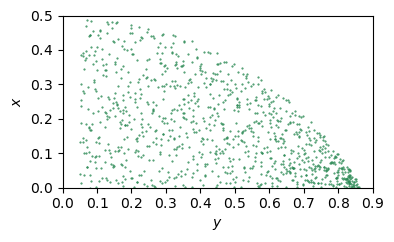

In [20]:
# Create a figure.
fig = plt.figure(num = 'Sample', figsize = (4.0, 2.25))

# Create a subplot.
ax = fig.add_subplot(1, 1, 1)

# Set aspect of the plot to equal.
ax.set_aspect('equal')

# Plot the coordinates of characteristic points from the generated sample.
ax.plot(
    df_sample.y_1,
    df_sample.x_1,
    color = 'seagreen',
    linestyle = 'None',
    marker = '.',
    ms = 1
)

# Set axis labels.
ax.set_xlabel("$ y $")
ax.set_ylabel("$ x $")

# Set ticks.
ax.set_xticks(ticks['y_1'])
ax.set_yticks(ticks['x_1'])

# Set tick labels.
ax.set_xticklabels(ticklabels['y_1'])
ax.set_yticklabels(ticklabels['x_1'])

# Set axis limits.
ax.set_xlim(lim['y_1'])
ax.set_ylim(lim['x_1'])

# Save the figure.
fig.savefig('../sample.pdf', bbox_inches = 'tight')

# Show the plot.
plt.show()


In [21]:
# Free the memory.
del fig
del ax


In [22]:
# Compute quantiles (20 % intervals) of y_1 on `df_sample`.
y_quant = np.array(
    np.concatenate(
        (
            [min(df_balanced.y_1.min(), df.y_1.min())],
            [
                df_sample.y_1.quantile(float("0.{p:02d}".format(p = i)))
                    for i in range(5, 96, 5)
            ],
            [max(df_balanced.y_1.min(), df.y_1.max())]
        )
    ),
    dtype = float,
    copy = True,
    order = 'F',
    subok = False,
    ndmin = 1
)
try:
    del i
except (NameError, UnboundLocalError):
    pass

# Extend extreme values by 10^(-8).
y_quant[0] -= 1.0e-8
y_quant[-1] += 1.0e-8


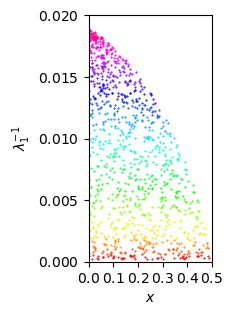

In [23]:
# Create a figure.
fig = plt.figure(num = 'Sample: x, lambda_0', figsize = (2.4, 3.2))

# Create a subplot.
ax = fig.add_subplot(1, 1, 1)

# Set the aspect of the plot to 50.
ax.set_aspect(50.0)

# Generate a spectrum of n equidistant colours, where n is the number of
# quantiles of y_1.
col = rainbow(int(y_quant.size) - 1)

# Plot lambda_0 over x_1 by quantiles of y_1.  Colour each set of points the
# corresponding colour.
for i in range(int(y_quant.size) - 1):
    ax.plot(
        df_sample.loc[
            (df_sample.y_1 >= y_quant[i]) & (df_sample.y_1 < y_quant[i + 1]),
            'x_1'
        ],
        df_sample.loc[
            (df_sample.y_1 >= y_quant[i]) & (df_sample.y_1 < y_quant[i + 1]),
            'l_0'
        ] ** -1,
        color = col[i],
        linestyle = 'None',
        marker = '.',
        ms = 1
    )
try:
    del i
except (NameError, UnboundLocalError):
    pass

# Free the memory.
del col

# Set axis labels.
ax.set_xlabel("$ x $")
ax.set_ylabel("$ \lambda_{1}^{{- 1}} $")

# Set ticks.
ax.set_xticks(ticks['x_1'])
ax.set_yticks(ticks['l_0_inv'])

# Set tick labels.
ax.set_xticklabels(ticklabels['x_1'])
ax.set_yticklabels(ticklabels['l_0_inv'])

# Set axis limits.
ax.set_xlim(lim['x_1'])
ax.set_ylim(lim['l_0_inv'])

# Save the figure.
fig.savefig('../x-lambda.pdf', bbox_inches = 'tight')

# Show the plot.
plt.show()


In [24]:
# Free the memory.
del fig
del ax


In [25]:
# Free the memory.
del y_quant


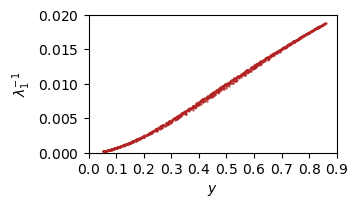

In [26]:
# Create a figure.
fig = plt.figure(num = 'Sample: y, lambda_0', figsize = (3.2, 2.4))

# Create a subplot.
ax = fig.add_subplot(1, 1, 1)

# Set the aspect of the subplot to 25.
ax.set_aspect(25.0)

# Plot lambda_0 over y_1.
ax.plot(
    df_sample.y_1,
    df_sample.l_0 ** -1,
    color = 'firebrick',
    linestyle = 'None',
    marker = '.',
    ms = 1
)

# Set axis labels.
ax.set_xlabel("$ y $")
ax.set_ylabel("$ \lambda_{1}^{{- 1}} $")

# Set ticks.
ax.set_xticks(ticks['y_1'])
ax.set_yticks(ticks['l_0_inv'])

# Set tick labels.
ax.set_xticklabels(ticklabels['y_1'])
ax.set_yticklabels(ticklabels['l_0_inv'])

# Set axis limits.
ax.set_xlim(lim['y_1'])
ax.set_ylim(lim['l_0_inv'])

# Save the figure.
fig.savefig('../y-lambda.pdf', bbox_inches = 'tight')

# Show the plot.
plt.show()


In [27]:
# Free the memory.
del fig
del ax


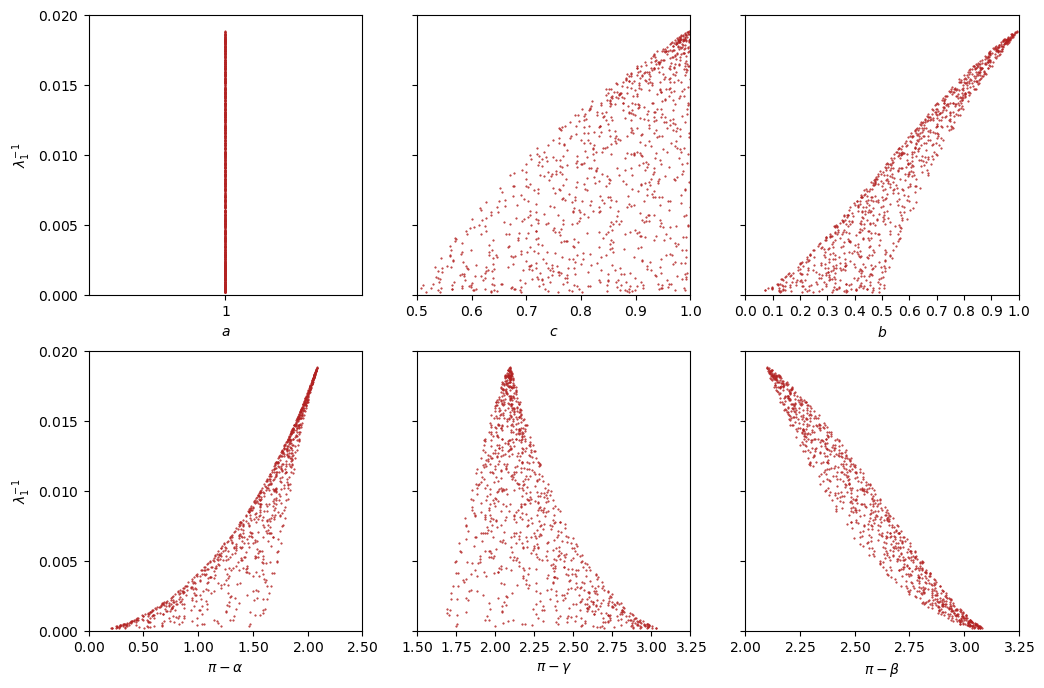

In [28]:
# Create a figure and 2 x 3 subplots.
fig, ax = plt.subplots(
    num = 'Sample: edges/angles, lambda_0',
    figsize = (12.0, 8.0),
    nrows = 2,
    ncols = 3,
    sharex = False,
    sharey = True
)

# Define names of edges and angles.
edge = ('a', 'c', 'b')
angle = ('alpha', 'gamma', 'beta')

# Plot lambda_0 over the lengths of edges in the top row of subplots.
for i in range(3):
    # Plot the data.
    ax[0, i].plot(
        df_sample[edge[i]],
        df_sample.l_0 ** -1,
        color = 'firebrick',
        linestyle = 'None',
        marker = '.',
        ms = 1
    )

    # Set the x-axis label.
    ax[0, i].set_xlabel("$ {e:s} $".format(e = edge[i]))
try:
    del i
except (NameError, UnboundLocalError):
    pass

# Plot lambda_0 over the outer angles in the bottom row of subplots.
for i in range(3):
    # Plot the data.
    ax[1, i].plot(
        df_sample[angle[i]],
        df_sample.l_0 ** -1,
        color = 'firebrick',
        linestyle = 'None',
        marker = '.',
        ms = 1
    )

    # Set the y-axis label.
    ax[1, i].set_xlabel("$ \\pi - \\{a:s} $".format(a = angle[i]))
try:
    del i
except (NameError, UnboundLocalError):
    pass

# Set the y-axis label on the leftmost subplots in each row.
for i in range(2):
    ax[i, 0].set_ylabel("$ \\lambda_{1}^{{- 1}} $")
try:
    del i
except (NameError, UnboundLocalError):
    pass

# Set ticks, tick labels and limits of the subplots.
for i in range(2):
    for j in range(3):
        # Set ticks.
        ax[i, j].set_xticks(ticks[angle[j] if i else edge[j]])
        ax[i, j].set_yticks(ticks['l_0_inv'])

        # Set tick labels.
        ax[i, j].set_xticklabels(ticklabels[angle[j] if i else edge[j]])
        ax[i, j].set_yticklabels(ticklabels['l_0_inv'])

        # Set axis limits.
        ax[i, j].set_xlim(lim[angle[j] if i else edge[j]])
        ax[i, j].set_ylim(lim['l_0_inv'])
    try:
        del j
    except (NameError, UnboundLocalError):
        pass
try:
    del i
except (NameError, UnboundLocalError):
    pass

# Free the memory.
del edge
del angle

# Save the figure.
fig.savefig('../edge_angle-lambda.pdf', bbox_inches = 'tight')

# Show the plots.
plt.show()


In [29]:
df.shape


(1129448, 19)

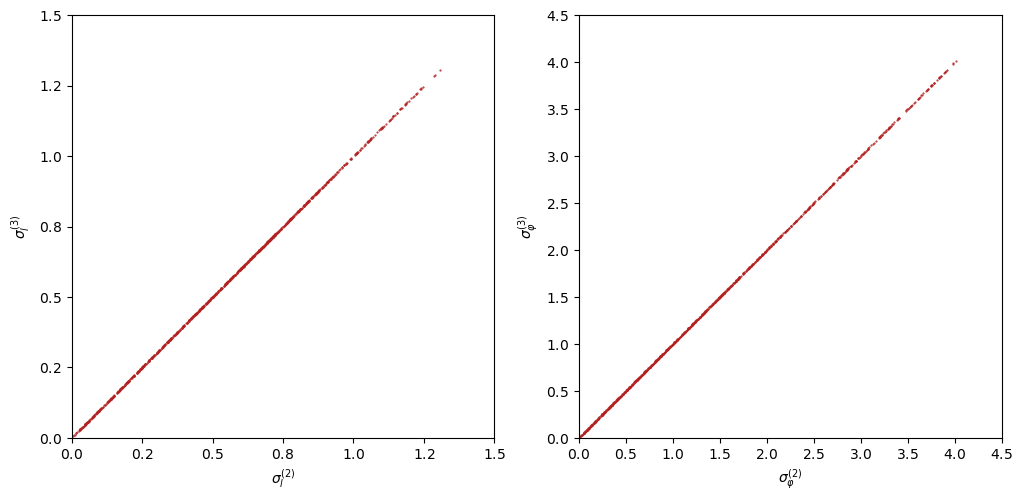

In [30]:
# Create a figure and 2 subplots.
fig, ax = plt.subplots(
    num = 'Sample: singular values',
    figsize = (12.0, 6.75),
    nrows = 1,
    ncols = 2
)

# Set aspects of subplots to equal.
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')

# Plot sv_edge_2 over sv_edge_1 on the left plot.
ax[0].plot(
    df_sample.sv_edge_1,
    df_sample.sv_edge_2,
    color = 'firebrick',
    linestyle = 'None',
    marker = '.',
    ms = 1
)

# Plot sv_angle_2 over sv_angle_1 on the right plot.
ax[1].plot(
    df_sample.sv_angle_1,
    df_sample.sv_angle_2,
    color = 'firebrick',
    linestyle = 'None',
    marker = '.',
    ms = 1
)

# Set axis labels on the left plot.
ax[0].set_xlabel("$ \\sigma_{l}^{\\left( 2 \\right)} $")
ax[0].set_ylabel("$ \\sigma_{l}^{\\left( 3 \\right)} $")

# Set ticks on the left plot.
ax[0].set_xticks(ticks['sv_edge_1'])
ax[0].set_yticks(ticks['sv_edge_2'])

# Set tick labels on the left plot.
ax[0].set_xticklabels(ticklabels['sv_edge_1'])
ax[0].set_yticklabels(ticklabels['sv_edge_2'])

# Set axis limits on the left plot.
ax[0].set_xlim(lim['sv_edge_1'])
ax[0].set_ylim(lim['sv_edge_2'])

# Set axis labels on the right plot.
ax[1].set_xlabel("$ \\sigma_{\\varphi}^{\\left( 2 \\right)} $")
ax[1].set_ylabel("$ \\sigma_{\\varphi}^{\\left( 3 \\right)} $")

# Set ticks on the right plot.
ax[1].set_xticks(ticks['sv_angle_1'])
ax[1].set_yticks(ticks['sv_angle_2'])

# Set tick labels on the right plot.
ax[1].set_xticklabels(ticklabels['sv_angle_1'])
ax[1].set_yticklabels(ticklabels['sv_angle_2'])

# Set axis limits on the right plot.
ax[1].set_xlim(lim['sv_angle_1'])
ax[1].set_ylim(lim['sv_angle_2'])

# Save the figure.
fig.savefig('../sv-sv.pdf', bbox_inches = 'tight')

# Show the plots.
plt.show()


In [31]:
# Free the memory.
del fig
del ax


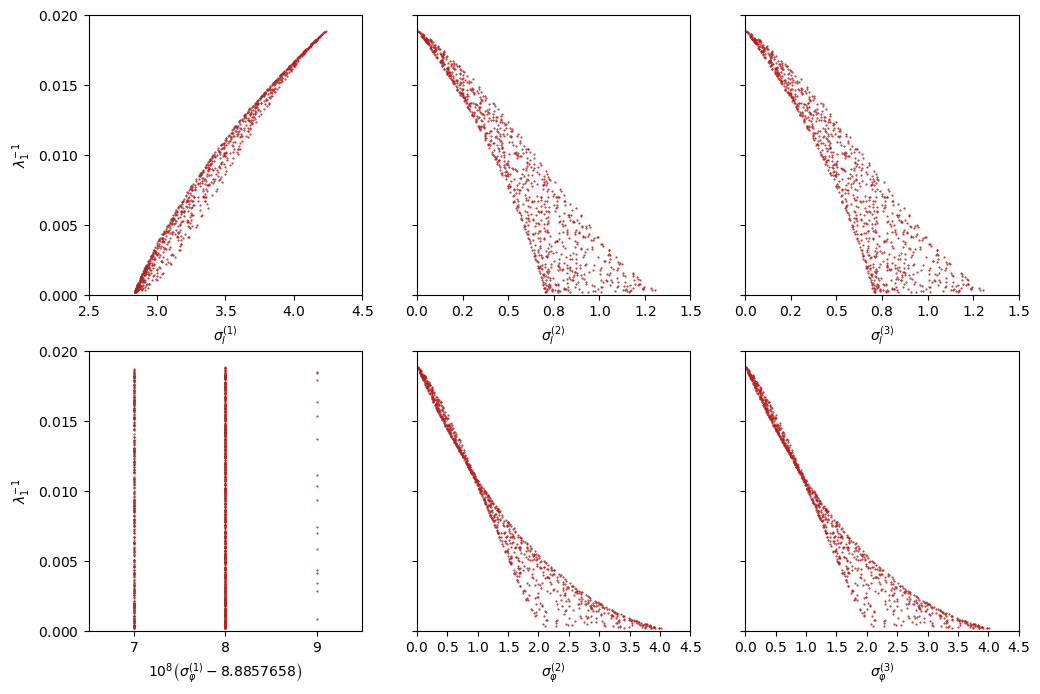

In [32]:
# Create a figure and 2 x 3 subplots.
fig, ax = plt.subplots(
    num = 'Sample: singular values, lambda_0',
    figsize = (12.0, 8.0),
    nrows = 2,
    ncols = 3,
    sharex = False,
    sharey = True
)

# Plot lambda_0 over the singular values of the lengths of edges in the top row
# of subplots.
for i in range(3):
    # Plot the data.
    ax[0, i].plot(
        df_sample["sv_edge_{ind:d}".format(ind = i)],
        df_sample.l_0 ** -1,
        color = 'firebrick',
        linestyle = 'None',
        marker = '.',
        ms = 1
    )

    # Set the x-axis label.
    ax[0, i].set_xlabel(
        "$ \\sigma_{{l}}^{{\\left( {ind:d} \\right)}} $".format(ind = i + 1)
    )
try:
    del i
except (NameError, UnboundLocalError):
    pass

# Plot lambda_0 over the singular values of the outer angles in the bottom row
# of subplots.
for i in range(3):
    # Plot the data.
    ax[1, i].plot(
        df_sample["sv_angle_{ind:d}".format(ind = i)],
        df_sample.l_0 ** -1,
        color = 'firebrick',
        linestyle = 'None',
        marker = '.',
        ms = 1
    )

    # Set the x-axis label.
    ax[1, i].set_xlabel(
        (
            "$ \\sigma_{{\\varphi}}^{{\\left( {ind:d} \\right)}} $"
                if i else (
                    "$ 10^{{8}} \\left( \\sigma_{{\\varphi}}^{{\\left( "
                        "{ind:d} \\right)}} - 8.8857658 \\right) $"
                )
        ).format(ind = i + 1)
    )
try:
    del i
except (NameError, UnboundLocalError):
    pass

# Set the y-axis label on the leftmost subplots in each row.
for i in range(2):
    ax[i, 0].set_ylabel("$ \\lambda_{1}^{{- 1}} $")
try:
    del i
except (NameError, UnboundLocalError):
    pass

# Set ticks, tick labels and limits of the subplots.
for i in range(2):
    for j in range(3):
        # Set ticks.
        ax[i, j].set_xticks(
            ticks[
                "sv_{arg:s}_{ind:d}".format(
                    arg = 'angle' if i else 'edge',
                    ind = j
                )
            ]
        )
        ax[i, j].set_yticks(ticks['l_0_inv'])

        # Set tick labels.
        ax[i, j].set_xticklabels(
            ticklabels[
                "sv_{arg:s}_{ind:d}".format(
                    arg = 'angle' if i else 'edge',
                    ind = j
                )
            ]
        )
        ax[i, j].set_yticklabels(ticklabels['l_0_inv'])

        # Set axis limits.
        ax[i, j].set_xlim(
            lim[
                "sv_{arg:s}_{ind:d}".format(
                    arg = 'angle' if i else 'edge',
                    ind = j
                )
            ]
        )
        ax[i, j].set_ylim(lim['l_0_inv'])
    try:
        del j
    except (NameError, UnboundLocalError):
        pass
try:
    del i
except (NameError, UnboundLocalError):
    pass

# Save the figure.
fig.savefig('../sv-lambda.pdf', bbox_inches = 'tight')

# Show the plot.
plt.show()


In [33]:
# Free the memory.
del fig
del ax
